In [1]:
# Requires Pip Install
# pip install xgboost

In [2]:
# Import the data
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

og_df = pd.read_csv('./original dataset/fake_job_postings.csv')
og_form = pd.read_csv('./formatted dataset/fake_job_postings.csv')

df = og_df.copy()
form = og_form.copy()

display(df.head())

display(form.head())

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


,job_id,title,country,state,city,department,salary_min,salary_max,company_profile,description,...,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,us,ny,new york,Marketing,-1.0,-1.0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",...,NaN,0,1,0,Other,Internship,Undefined,Undefined,Marketing,0
1,2,Customer Service - Cloud Video Production,nz,NaN,auckland,Success,-1.0,-1.0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Undefined,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),us,ia,wever,Undefined,-1.0,-1.0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",...,NaN,0,1,0,Undefined,Undefined,Undefined,Undefined,Undefined,0
3,4,Account Executive - Washington DC,us,dc,washington,Sales,-1.0,-1.0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,...,Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,us,fl,fort worth,Undefined,-1.0,-1.0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
data_leak = ['job_id']
form.drop(data_leak, axis=1, inplace=True)
df.drop(data_leak, axis=1, inplace=True)

# removing the categorical columns for a baseline test
df.drop(['company_profile','description','requirements','benefits','location','salary_range','title'], axis=1, inplace=True)
form.drop(['company_profile','description','requirements','benefits','title'], axis=1, inplace=True)

# creating a df with some categorical fields that aren't long text fields
categorical=['employment_type', 'required_experience', 'required_education', 'industry', 'function']
df_categorical = df.copy()

# Drop the remaining categorical columns from the original DataFrame
df.drop(categorical, axis=1, inplace=True)
form.drop(categorical, axis=1, inplace=True)

df_categorical = df_categorical.fillna('Unknown')
form['country'] = form['country'].fillna('Unknown')
df['department'] = df['department'].fillna('Unknown')
df = df.fillna(0)

# set the type to category for the XGB DMatrix to handle when flagging for categorical columns
df_categorical[categorical] = df_categorical[categorical].astype('category')

# Train Test Split

In [4]:
# most basic model

x = df.drop(['fraudulent'], axis=1)
y = df['fraudulent']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# build with oversampling

x_os = df.drop(['fraudulent'], axis=1)
y_os = df['fraudulent']

x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x_os, y_os, test_size=0.2, random_state=0)

# build for oversampling and categorical fields

x_os_cat = df_categorical.drop(['fraudulent'], axis=1)
y_os_cat = df_categorical['fraudulent']

x_train_os_cat, x_test_os_cat, y_train_os_cat, y_test_os_cat = train_test_split(x_os_cat, y_os_cat, test_size=0.2, random_state=0)

# build for oversampling with formatted data

x_form = form.drop(['fraudulent'], axis=1)
y_form = form['fraudulent']

x_train_form, x_test_form, y_train_form, y_test_form = train_test_split(x_form, y_form, test_size=0.2, random_state=0)

# Transform data after splitting

In [5]:
# implement one hot encoding for department
ohe = OneHotEncoder(min_frequency=20, handle_unknown="ignore")

dept_encoded = ohe.fit_transform(x_train[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
x_train = x_train.join(dept_df.fillna(-1))
x_train.drop(['department'], axis=1, inplace=True)

dept_encoded = ohe.transform(x_test[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
x_test = x_test.join(dept_df.fillna(-1))
x_test.drop(['department'], axis=1, inplace=True)

dept_encoded = ohe.fit_transform(x_train_os[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
x_train_os = x_train_os.join(dept_df.fillna(-1))
x_train_os.drop(['department'], axis=1, inplace=True)

dept_encoded = ohe.transform(x_test_os[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
x_test_os = x_test_os.join(dept_df.fillna(-1))
x_test_os.drop(['department'], axis=1, inplace=True)

dept_encoded = ohe.fit_transform(x_train_os_cat[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
dept_df = dept_df.fillna(-1)
x_train_os_cat = x_train_os_cat.join(dept_df)
x_train_os_cat.drop(['department'], axis=1, inplace=True)
# x_train_os_cat = x_train_os_cat.fillna(-1)

dept_encoded = ohe.transform(x_test_os_cat[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
x_test_os_cat = x_test_os_cat.join(dept_df.fillna(-1))
x_test_os_cat.drop(['department'], axis=1, inplace=True)

dept_encoded = ohe.fit_transform(x_train_form[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
x_train_form = x_train_form.join(dept_df.fillna(-1))
x_train_form.drop(['department'], axis=1, inplace=True)

dept_encoded = ohe.transform(x_test_form[['department']])
dept_encoded_dense = dept_encoded.toarray()
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))
x_test_form = x_test_form.join(dept_df.fillna(-1))
x_test_form.drop(['department'], axis=1, inplace=True)

x_train = x_train.fillna(-1)
x_test = x_test.fillna(-1)
x_train_os = x_train_os.fillna(-1)
x_test_os = x_test_os.fillna(-1)
x_train_form = x_train_form.fillna(-1)
x_test_form = x_test_form.fillna(-1)

x_train.head()

,telecommuting,has_company_logo,has_questions,department_Accounting,department_Administration,department_Administrative,department_Business Development,department_CSD Relay,department_Clerical,department_Client Services,...,department_Production,department_R&D,department_Retail,department_Sales,department_Tech,department_Technical,department_Technology,department_Unknown,department_tech,department_infrequent_sklearn
14360,0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7053,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17870,0,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9228,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4160,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
# Extra cleanup for the formatted dataset

x_train_form[['city', 'state', 'country']] = x_train_form[['city', 'state', 'country']].fillna("Unknown").astype('category')
x_test_form[['city', 'state', 'country']] = x_test_form[['city', 'state', 'country']].fillna("Unknown").astype('category')

x_test_form.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3576 entries, 9256 to 11512
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   country                            3576 non-null   category
 1   state                              3576 non-null   category
 2   city                               3576 non-null   category
 3   salary_min                         3576 non-null   float64 
 4   salary_max                         3576 non-null   float64 
 5   telecommuting                      3576 non-null   int64   
 6   has_company_logo                   3576 non-null   int64   
 7   has_questions                      3576 non-null   int64   
 8   department_Accounting              3576 non-null   float64 
 9   department_Administration          3576 non-null   float64 
 10  department_Administrative          3576 non-null   float64 
 11  department_Business Development    3576 non-

In [7]:
# Apply SMOTE to the training data now that the department column has been one-hot encoded
smote = SMOTE(random_state=42)

# x_train_os = x_train_os.replace([None, ''], np.nan)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_os, y_train_os)

In [8]:
# Encode categorical variables in x_train_form
# x_train_form_encoded = pd.get_dummies(x_train_form)
x_train_os_cat_encoded = pd.get_dummies(x_train_os_cat)

# also update x_test for same variables
# x_test_form_encoded = pd.get_dummies(x_test_form)
x_test_os_cat_encoded = pd.get_dummies(x_test_os_cat)

# getting errors that x_train_os_cat_encoded has NaN's
x_train_os_cat_encoded.fillna(-1, inplace=True)

# Apply SMOTE to the encoded training data
x_train_os_cat_resampled, y_train_os_cat_resampled = smote.fit_resample(x_train_os_cat_encoded, y_train_os_cat)

# Apply SMOTE to the encoded training data
# x_train_form_resampled, y_train_form_resampled = smote.fit_resample(x_train_form_encoded, y_train_form)


In [9]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
x_train_unders_cat, y_train_unders_cat = rus.fit_resample(x_train_os_cat_encoded, y_train_os_cat)


# Fit Models with train and test data

In [10]:
# Use test and train dataframes to create a DMatrix

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

dtrain_os = xgb.DMatrix(x_train_resampled, label=y_train_resampled)
dtest_os = xgb.DMatrix(x_test_os, label=y_test_os)

dtrain_os_cat = xgb.DMatrix(x_train_os_cat_resampled, label=y_train_os_cat_resampled, enable_categorical=True)
dtest_os_cat = xgb.DMatrix(x_test_os_cat_encoded, label=y_test_os_cat, enable_categorical=True)

dtrain_form = xgb.DMatrix(x_train_form, label=y_train_form, enable_categorical=True)
dtest_form = xgb.DMatrix(x_test_form, label=y_test_form, enable_categorical=True)


# Train Models

In [11]:
# set params and train the DMatrix
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
num_round = 10

xg_model = xgb.train(params, dtrain, num_round)
xg_model_os = xgb.train(params, dtrain_os, num_round)
xg_model_os_cat = xgb.train(params, dtrain_os_cat, num_round)
xg_model_form = xgb.train(params, dtrain_form, num_round)

# Predict

In [12]:
# predict the xg model
preds = xg_model.predict(dtest)
preds_os = xg_model_os.predict(dtest_os)
preds_os_cat = xg_model_os_cat.predict(dtest_os_cat)
preds_form = xg_model_form.predict(dtest_form)

# convert the predictions to binary
preds_binary = (preds >= 0.5).astype(int)
preds_binary_os = (preds_os >= 0.5).astype(int)
preds_binary_os_cat = (preds_os_cat >= 0.5).astype(int)
preds_binary_form = (preds_form >= 0.5).astype(int)

# check accuracy of the models
print('Base Model: ', balanced_accuracy_score(y_test, preds_binary))
print('Oversampled Model: ', balanced_accuracy_score(y_test_os, preds_binary_os))
print('Oversample Categorized Model: ', balanced_accuracy_score(y_test_os_cat, preds_binary_os_cat))
print('Formatted Model: ', balanced_accuracy_score(y_test_form, preds_binary_form))

Base Model:  0.508489285284666
Oversampled Model:  0.7249145056795725
Oversample Categorized Model:  0.804205117629874
Formatted Model:  0.5108808349515676


# Review Predictions

Confusion Matrix:
[[3414    9]
 [ 150    3]]


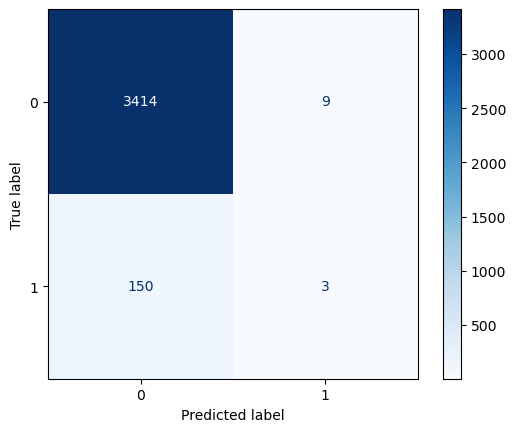

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds_binary)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[2815  608]
 [  57   96]]


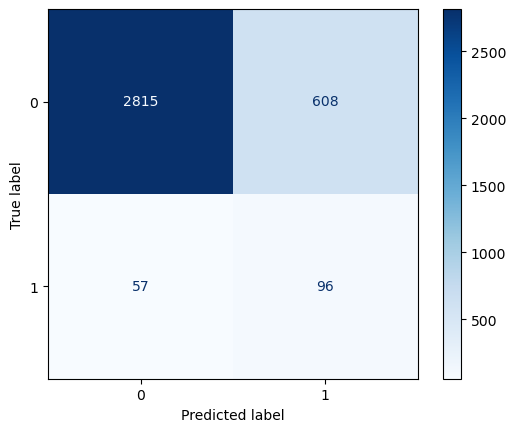

In [14]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_os, preds_binary_os)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[2888  535]
 [  36  117]]


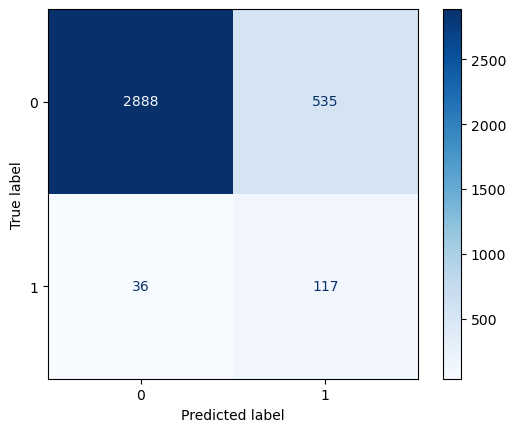

In [15]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_os_cat, preds_binary_os_cat)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Introduce XGBClassifier model

In [16]:
from xgboost import XGBClassifier

In [17]:
xgbc = XGBClassifier(n_estimators=136, max_depth=4, learning_rate=.13, random_state=1)

# fit the model
xgbc.fit(x_train_os, y_train_os)

# Make predictions
train_pred_xgbc = xgbc.predict(x_train_os)
test_pred_xgbc = xgbc.predict(x_test_os)

train_pred_xgbc_form = xgbc.predict(x_train_os)
test_pred_xgbc_form = xgbc.predict(x_test_os)

In [18]:
xgbc_form = XGBClassifier(n_estimators=136, max_depth=4, learning_rate=.13, random_state=1, enable_categorical=True)

# fit the model
xgbc_form.fit(x_train_form, y_train_form)

# Make predictions
train_pred_xgbc_form = xgbc_form.predict(x_train_form)
test_pred_xgbc_form = xgbc_form.predict(x_test_form)

In [19]:
xgbc_os_cat = XGBClassifier(n_estimators=136, max_depth=4, learning_rate=.13, random_state=1, enable_categorical=True)

# fit the model
xgbc_os_cat.fit(x_train_os_cat, y_train_os_cat)

# Make predictions
train_pred_xgbc_os_cat = xgbc_os_cat.predict(x_train_os_cat)
test_pred_xgbc_os_cat = xgbc_os_cat.predict(x_test_os_cat)

In [20]:

print('\nRandom Oversampled with XGB Classifer')
# Print scores
print("--------------------------------------------------------")
print(balanced_accuracy_score(y_train_os, train_pred_xgbc),'training score')
print(balanced_accuracy_score(y_test_os, test_pred_xgbc),'testing score')

print('\nRandom Oversample Categorized Model with XGB Classifer')
# Print scores
print("--------------------------------------------------------")
print(balanced_accuracy_score(y_train_os_cat, train_pred_xgbc_os_cat),'training score')
print(balanced_accuracy_score(y_test_os_cat, test_pred_xgbc_os_cat),'testing score')

print('\nRandom Oversampled and formatted Data with XGB Classifer')
# Print scores
print("--------------------------------------------------------")
print(balanced_accuracy_score(y_train_form, train_pred_xgbc_form),'training score')
print(balanced_accuracy_score(y_test_form, test_pred_xgbc_form),'testing score')


Random Oversampled with XGB Classifer
--------------------------------------------------------
0.5080840458008729 training score
0.508489285284666 testing score

Random Oversample Categorized Model with XGB Classifer
--------------------------------------------------------
0.8235462416707369 training score
0.8164263660474415 testing score

Random Oversampled and formatted Data with XGB Classifer
--------------------------------------------------------
0.7636101173710059 training score
0.524390942471058 testing score


Confusion Matrix:
[[3352   71]
 [  53  100]]


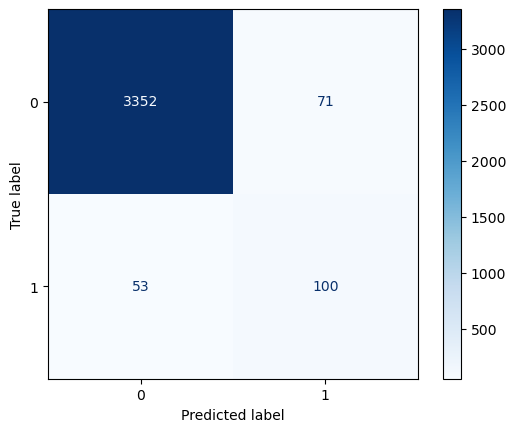

In [21]:
# Calculate the confusion matrix
preds_binary_xgbc_os_cat = (test_pred_xgbc_os_cat >= 0.5).astype(int)
cm = confusion_matrix(y_test_os_cat, preds_binary_xgbc_os_cat)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test_os_cat, preds_binary_xgbc_os_cat)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3423
           1       0.58      0.65      0.62       153

    accuracy                           0.97      3576
   macro avg       0.78      0.82      0.80      3576
weighted avg       0.97      0.97      0.97      3576



In [23]:
# Try again with undersampling instead of oversampling

xgbc_os_cat = XGBClassifier(n_estimators=136, max_depth=4, learning_rate=.13, random_state=1, enable_categorical=True)

# fit the model
xgbc_os_cat.fit(x_train_unders_cat, y_train_unders_cat)

# Make predictions
train_pred_xgbc_us_cat = xgbc_os_cat.predict(x_train_unders_cat)
test_pred_xgbc_us_cat = xgbc_os_cat.predict(x_test_os_cat_encoded)

# x_test_os_cat_encoded, label=y_test_os_cat

print('\nRandom Oversample Categorized Model with XGB Classifer')
# Print scores
print("--------------------------------------------------------")
print(balanced_accuracy_score(y_train_unders_cat, train_pred_xgbc_us_cat),'training score')
print(balanced_accuracy_score(y_test_os_cat, test_pred_xgbc_us_cat),'testing score')


Random Oversample Categorized Model with XGB Classifer
--------------------------------------------------------
0.8920056100981767 training score
0.8387494056927474 testing score


Confusion Matrix:
[[3035  388]
 [  32  121]]


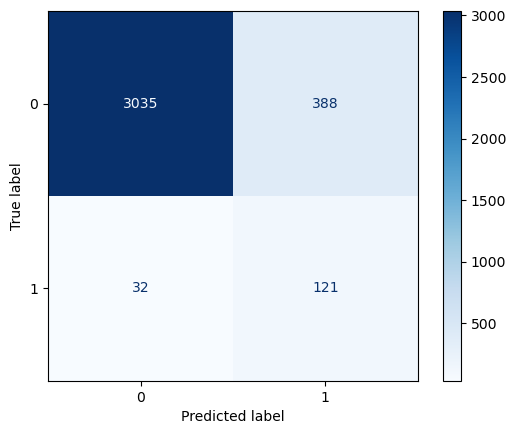

In [24]:
# Calculate the confusion matrix
preds_binary_xgbc_us_cat = (test_pred_xgbc_us_cat >= 0.5).astype(int)
cm = confusion_matrix(y_test_os_cat, preds_binary_xgbc_us_cat)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [25]:
report = classification_report(y_test_os_cat, preds_binary_xgbc_us_cat)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3423
           1       0.24      0.79      0.37       153

    accuracy                           0.88      3576
   macro avg       0.61      0.84      0.65      3576
weighted avg       0.96      0.88      0.91      3576



# Hyperparameter Tuning of 2 best model

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# n_estimators=136, max_depth=4, learning_rate=.13
final_hp_us = XGBClassifier(random_state=1, enable_categorical=True)
final_hp_os = XGBClassifier(random_state=1, enable_categorical=True)
param_grid = {
    'n_estimators': [100, 200, 300, 600],
    'max_depth': [None, 5, 10, 15],
    'learning_rate': [.01, .1, .15, .2, .25, .3, .35]
}
random_search_us = RandomizedSearchCV(final_hp_us, param_distributions=param_grid, n_iter=10, cv=5, scoring='average_precision')
random_search_os = RandomizedSearchCV(final_hp_os, param_distributions=param_grid, n_iter=10, cv=5, scoring='average_precision')
# Fit the model
random_search_us.fit(x_train_unders_cat, y_train_unders_cat)
random_search_os.fit(x_train_os_cat, y_train_os_cat)
# Get the best parameters
best_params = random_search_us.best_params_
print('Best Under Sample:\n',best_params)
best_params = random_search_os.best_params_
print('Best Over Sample:\n',best_params)
# Best for balanced accuracy
## Best Under Sample:
##  {'n_estimators': 600, 'max_depth': 15, 'learning_rate': 0.25}
## Best Over Sample:
##  {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1}
# Best for average_precision
# Best Under Sample:
#  {'n_estimators': 100, 'max_depth': None, 'learning_rate': 0.2}
# Best Over Sample:
#  {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.01}

Best Under Sample:
 {'n_estimators': 100, 'max_depth': None, 'learning_rate': 0.2}
Best Over Sample:
 {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.01}


In [27]:
# Best Undersampling Model

final_us = XGBClassifier(n_estimators=100, max_depth=None, learning_rate=.2, random_state=1, enable_categorical=True)

# fit the model
final_us.fit(x_train_unders_cat, y_train_unders_cat)

# Make predictions
train_pred_final_us = final_us.predict(x_train_unders_cat)
test_pred_final_us = final_us.predict(x_test_os_cat_encoded)

print('\nRandom Undersampled Categorized Model with Tuned XGB Classifer')
# Print scores
print("--------------------------------------------------------")
print(balanced_accuracy_score(y_train_unders_cat, train_pred_final_us),'training score')
print(balanced_accuracy_score(y_test_os_cat, test_pred_final_us),'testing score')

test_preds_binary_final_us = (test_pred_final_us >= 0.5).astype(int)
report = classification_report(y_test_os_cat, test_preds_binary_final_us)
print(report)


Random Undersampled Categorized Model with Tuned XGB Classifer
--------------------------------------------------------
0.9221598877980365 training score
0.8458696361980376 testing score
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3423
           1       0.24      0.80      0.37       153

    accuracy                           0.88      3576
   macro avg       0.62      0.85      0.65      3576
weighted avg       0.96      0.88      0.91      3576



In [28]:
# Best model with Oversampling

final_os = XGBClassifier(n_estimators=600, max_depth=10, learning_rate=.01, random_state=1, enable_categorical=True)

# fit the model
final_os.fit(x_train_os_cat, y_train_os_cat)

# Make predictions
train_pred_final_os = final_os.predict(x_train_os_cat)
test_pred_final_os = final_os.predict(x_test_os_cat)

print('\nRandom Oversample Categorized Model with Tuned XGB Classifer')
# Print scores
print("--------------------------------------------------------")
print(balanced_accuracy_score(y_train_os_cat, train_pred_final_os),'training score')
print(balanced_accuracy_score(y_test_os_cat, test_pred_final_os),'testing score')

test_preds_binary_final_os = (test_pred_final_os >= 0.5).astype(int)
report = classification_report(y_test_os_cat, test_preds_binary_final_os)
print(report)


Random Oversample Categorized Model with Tuned XGB Classifer
--------------------------------------------------------
0.8610442435556984 training score
0.8138887456823221 testing score
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3423
           1       0.60      0.65      0.62       153

    accuracy                           0.97      3576
   macro avg       0.79      0.81      0.80      3576
weighted avg       0.97      0.97      0.97      3576

